In [49]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [50]:
#firefly = pd.read_excel('Luo_et_al_2020_firefly_reporter_APA_factors.xlsx')
firefly = pd.read_csv('enching_fluc_table_all.txt', sep='\t', skiprows=1)[['RBP (ORFs)','Satisfied FDR <0.01', 'P value']]

In [51]:
#renilla = pd.read_excel('Luo_et_al_2020_renillia_reporter_result_for_APA_factors.xlsx')
renilla = pd.read_csv('enching_rluc_all_table.txt', sep='\t', skiprows=1)[['RBP (ORFs)','Satisfied FDR <0.01', 'P value']]

In [52]:
renilla.columns

Index(['RBP (ORFs)', 'Satisfied FDR <0.01', 'P value'], dtype='object')

In [53]:
downstream = pd.read_csv('downstream_activators_secondary_screen_allisos.txt', sep='\t')

In [54]:
upstream = pd.read_csv('upstream_activators_secondary_screen_allisos.txt', sep='\t')

In [55]:
downstream.shape

(85, 19)

In [56]:
full_library = pd.read_csv('/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/Updated-RBP_V5_MCP.txt', sep='\t')

In [57]:
def make_key(d):
    return f'{d["Symbol"]}_{"_".join([i.strip(" ") for i in str(d["Accession"]).replace(".", "-").split(",")])}'

In [58]:
full_library['key'] = full_library.apply(make_key, axis=1)

In [59]:
gene_to_sequence_dict = dict(zip(full_library.key, full_library.aa_sequence))
sequence_to_gene_dict = dict(zip(full_library.aa_sequence, full_library.key))

In [60]:
wellID_sequence_dict= dict(zip(full_library['aa_sequence'], full_library['Plate Location'])) # map plate location based on the sequence

In [61]:
redo_library = pd.read_csv('../activator_redo_list.txt', sep='\t')

In [62]:
redo_library['original_well'] = redo_library.aa_sequence.map(wellID_sequence_dict)

In [63]:
redo_library['key'] = redo_library.apply(make_key, axis=1)

In [64]:
redo_original_well_match = dict(zip(redo_library['Plate Location'], redo_library['original_well']))

In [65]:
redo_original_key_match = dict(zip(redo_library['original_well'], redo_library['key']))

In [66]:
def process_secondary_screen(df_re):
    '''process secondary screen data, only keeping the top isoform'''
    df_re['original_well'] = df_re.well_id.map(redo_original_well_match)
    df_re['key'] = df_re.original_well.map(redo_original_key_match)
    df_re['pvalue'] = df_re['pvalue'].apply(lambda x: float(f"{x:.2g}"))
    
    # only keep the top isoform and only keep activators
    df_re = df_re[(df_re['well_id']!='controls')].sort_values(by=['mean_normalized', 'pvalue'], ascending=[False, True]).drop_duplicates('index').copy()
    df_re = df_re[(df_re['pvalue'] <0.05)]
    df_re = df_re[(df_re['RBPmean-NEGmean'] >0)]
    return df_re

In [67]:
downstream_re = process_secondary_screen(downstream).dropna()

In [68]:
upstream_re = process_secondary_screen(upstream).dropna()

In [69]:
downstream_re.dropna().shape

(64, 19)

In [70]:
upstream_re.dropna().shape

(56, 19)

In [71]:
import re

In [72]:
def convert_identifier(s):
    match = re.match(r"^(\S+)\s*\((.+)\)$", s.strip())
    if match:
        gene, accs = match.groups()
        # split on comma, strip spaces, replace '.' with '-'
        accs = [a.strip().replace('.', '-') for a in accs.split(',')]
        return gene + "_" + "_".join(accs)
    return s  # return unchanged if no match

In [73]:
firefly['key'] = [convert_identifier(x) for x in firefly['RBP (ORFs)'].tolist()]

In [74]:
firefly = firefly[firefly['Satisfied FDR <0.01']=='Yes']

In [75]:
renilla['key'] = [convert_identifier(x) for x in renilla['RBP (ORFs)'].tolist()]

In [76]:
renilla = renilla[renilla['Satisfied FDR <0.01']=='Yes']

In [77]:
final_activators = pd.read_csv('final_activators.txt', sep='\t', header=None)[0].tolist()

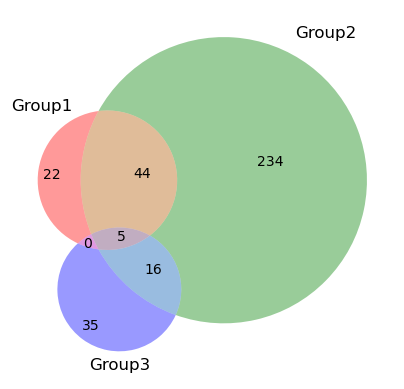

In [82]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

set1 = set(firefly['key'])
set2 = set(renilla['key'])
set3 = set(upstream_re['key'])

venn3([set1, set2, set3], ('Group1', 'Group2', 'Group3'))

plt.show()

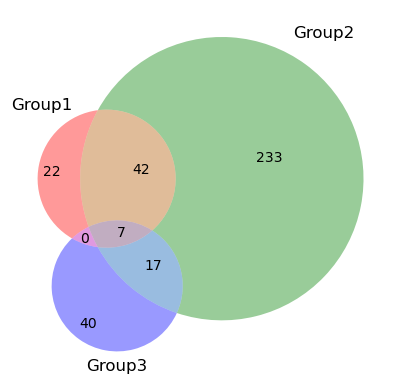

In [79]:
set1 = set(firefly['key'])
set2 = set(renilla['key'])
set3 = set(downstream_re['key'])

venn3([set1, set2, set3], ('Group1', 'Group2', 'Group3'))

plt.show()

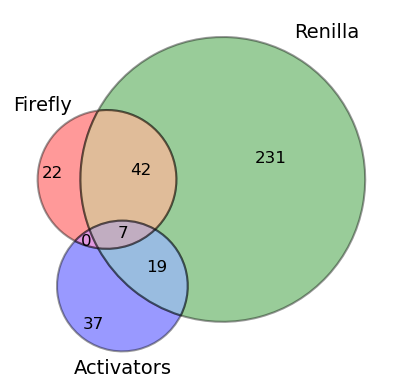

In [80]:
set1 = set(firefly['key'])
set2 = set(renilla['key'])
set3 = set(final_activators)

venn1 = venn3([set1, set2, set3], ('Firefly', 'Renilla', 'Activators'))


# Make outline thicker
for patch in venn1.patches:
    if patch:  # some subsets might be None
        patch.set_linewidth(1.5)   # thickness
        patch.set_edgecolor("black")

# Lower fill alpha (more transparent)
for patch in venn1.patches:
    if patch:
        patch.set_alpha(0.4)   # 0=fully transparent, 1=opaque

# Make font bigger
for label in venn1.set_labels:
    label.set_fontsize(14)   # set font size of set labels
for label in venn1.subset_labels:
    if label:  # some subsets may be None
        label.set_fontsize(12)   # set font size of subset labels
# plt.savefig('./figures/activator_translation_stability_comparison.png')
# plt.savefig('./figures/activator_translation_stability_comparison.svg')
# plt.savefig('./figures/activator_translation_stability_comparison.jpg')

plt.show()

In [44]:
set1.intersection(set3, set2)

{'CNOT2_BC011826',
 'CNOT4_BC035590-1',
 'CPSF5_BC001403',
 'EIF4A3_BC004386-1_BC011151-1',
 'NANOS3_BC101209-2',
 'PARN_BC050029-1',
 'RY1_BC017890-1'}

In [48]:
set2.intersection(set3) - set1

{'CPSF6_BC005000-1',
 'DZIP3_BC063882-1',
 'EIF4B_BC073139-1',
 'FUBP1_BC017247',
 'HNRNPF_BC004254-1',
 'HNRNPH2_BC130345-1',
 'MBNL1_BC043493-1',
 'MBNL2_BC104040-1',
 'PPP1CA_BC001888-1_BC004482-2_BC008010-1',
 'RBM22_AL136933',
 'SARNP_BC007099-1',
 'SPATS2L_BC018736-1',
 'SRP68_BC020238-1',
 'SRSF8_BC057783-1',
 'SYMPK_BC006567',
 'TFIP11_BC011599-2',
 'TRNAU1AP_BC000680-2',
 'U2AF2_BC008740-2',
 'ZRANB2_BC039814-1'}

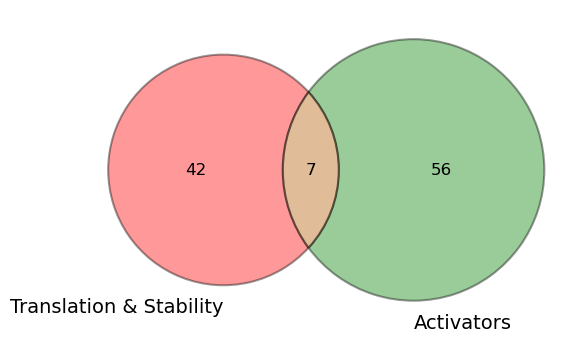

In [83]:
set1 = set(firefly['key'])
set2 = set(renilla['key'])
set3 = set(final_activators)

venn1 = venn2([set1.intersection(set2), set3], ('Translation & Stability', 'Activators'))


# Make outline thicker
for patch in venn1.patches:
    if patch:  # some subsets might be None
        patch.set_linewidth(1.5)   # thickness
        patch.set_edgecolor("black")

# Lower fill alpha (more transparent)
for patch in venn1.patches:
    if patch:
        patch.set_alpha(0.4)   # 0=fully transparent, 1=opaque

# Make font bigger
for label in venn1.set_labels:
    label.set_fontsize(14)   # set font size of set labels
for label in venn1.subset_labels:
    if label:  # some subsets may be None
        label.set_fontsize(12)   # set font size of subset labels
plt.savefig('./figures/activator_translation_stability_comparison.png')
plt.savefig('./figures/activator_translation_stability_comparison.svg')
plt.savefig('./figures/activator_translation_stability_comparison.jpg')

plt.show()